## Load up data and generate features

In [2]:
import sys
sys.path.append('..')

import audio
import features
import glob
import numpy as np

X_heli = None
X_boat = None

files = glob.glob("./*.wav")

for file in files:
    print("Loading " + file)
    raw = audio.import_wav(file)

    # Generate each type of feature
    corr = features.gen_correlogram(raw)
    mag_spec = features.gen_mag_spec(raw)
    
    # Combine into a single vector for each observation
    f_vect = np.concatenate((corr.T, mag_spec), axis=1)
    #f_vect = mag_spec.T
    
    # Combine all observations into a single matrix
    X_heli = f_vect

# Assign labels manually
#Y_boat = np.zeros((X_boat.shape[0], 1))
#Y_heli = np.ones((X_heli.shape[0], 1))

print("Nice!")

Loading ./2sdGC6A60GA.wav
Nice!


## Check output

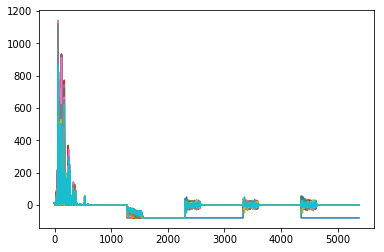

(4421, 5380)

In [3]:
import matplotlib.pyplot as plt

plt.plot(X_heli[:50, :].T)
plt.show()
X_heli.shape

## Train model

In [4]:
from sklearn.mixture import GaussianMixture as GMM

train_boat = X_boat[:-5120]
train_heli = X_heli[:-5120]
test_boat = X_boat[-5120:]
test_heli = X_heli[-5120:]

gmm = {'boat':None, 'heli':None}

gmm["boat"] = GMM(n_components=2)
gmm["boat"].fit(train_boat)

gmm["heli"] = GMM(n_components=2)
gmm["heli"].fit(train_heli)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=2, n_init=1, precisions_init=None,
        random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

## Predict

In [5]:
test_full = np.concatenate((test_boat, test_heli), axis = 0)
test_labels = np.concatenate((np.zeros((test_boat.shape[0], 1)), np.ones((test_heli.shape[0], 1))), axis = 0)

scores = np.zeros((test_full.shape[0], 2))

scores[:, 0] = gmm["boat"].score_samples(test_full)
scores[:, 1] = gmm["heli"].score_samples(test_full)

pred = np.greater(scores[:, 1], scores[:, 0])
error = np.not_equal(pred, np.squeeze(test_labels))

error_rate = np.sum(error) / len(error)
print(error_rate)

0.27216796875
